### Imports

In [2]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
# from DataLoaderUrbanSounds import DataLoaderUrbanSounds

### Sample audio

In [3]:
librosa_audio_data, librosa_sample_rate = librosa.load('UrbanSound8K/audio/fold4/7389-1-0-6.wav')

(88200,)


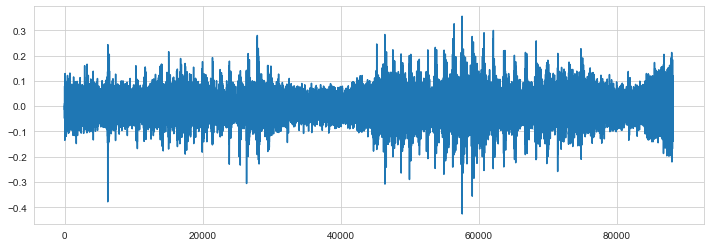

In [4]:
print(librosa_audio_data.shape)
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
ipd.Audio('UrbanSound8K/audio/fold4/7389-1-0-6.wav')

In [5]:
y, sr = librosa.load('UrbanSound8K/audio/fold4/7389-1-0-6.wav', res_type='kaiser_fast')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

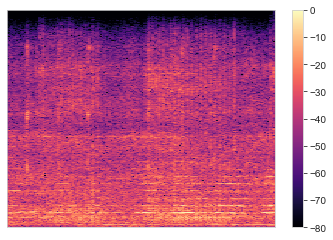

In [6]:
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

### Exploring Metadata

In [7]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<AxesSubplot:>

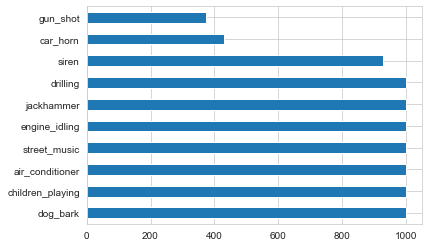

In [8]:
metadata['class'].value_counts().plot(kind='barh')

### Training method

In [9]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


def train(model, num_epochs, num_batch_size, X_train, y_train, X_test, y_test):
    ## Trianing my model
    checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                                   verbose=1, save_best_only=True)
    start = datetime.now()

    # history = model.fit(X_train, y_train, validation_split=0.2, batch_size=num_batch_size, epochs=num_epochs,
    #                     callbacks=[checkpointer], verbose=1)
    history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpointer], verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)

    return history

**instantiate DataLoaderUrbanSound class**

In [10]:
from DataLoaderUrbanSounds import DataLoaderUrbanSounds

dl = DataLoaderUrbanSounds(40)  # you can choose your own dim

**extract features from all aduio files**


In [11]:
dl.extract_features()

3554it [02:41, 22.10it/s]C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [06:05, 34.29it/s]C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\ditli\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [06:21, 22.92it/s]


**Get Training Data**

In [12]:
# get X (train) data
X, _ = dl.get_train_test_data()

# get y (target) based on the encoder to use
y = dl.get_target_as_one_hot_encoder()
# y = dl.get_target_as_label_encoder()

In [13]:
X = X.reshape(-1, 40, 1)

In [14]:
X.shape

(8732, 40, 1)

**split data into train and test**

In [15]:
X_train, X_test, y_train, y_test = dl.split_to_train_test_data(X, y, 0.3);
# X_train, X_v_test, y_train, y_v_test = dl.split_to_train_test_data(X_train, y_train, 0.3);

In [16]:
X_train.shape

(6112, 40, 1)

## Build model and feed in the data

In [4]:
from keras import Sequential
from keras.layers import Dense, Dropout

In [18]:
### No of classes
num_labels = y.shape[1]

In [6]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 38, 64)            256       
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 36, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                73792     
                                                      

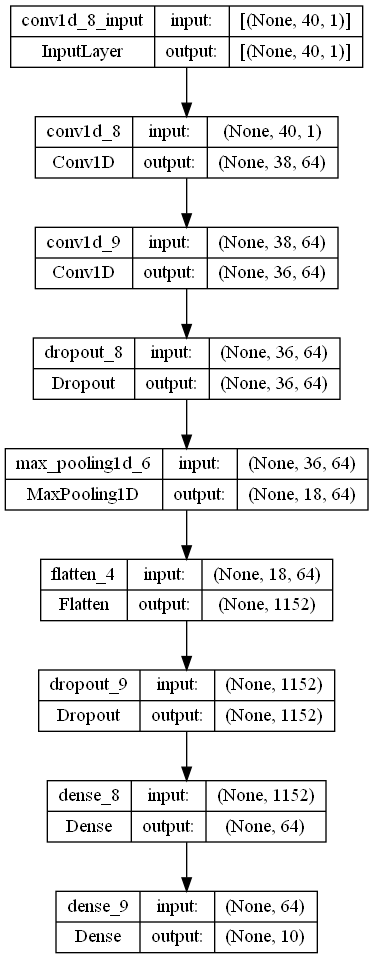

In [64]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [67]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
num_epochs = 200
num_batch_size = 32
history = train(model, num_epochs, num_batch_size, X_train, y_train, X_test, y_test)

Epoch 1/200
182/191 [===========================>..] - ETA: 0s - loss: 2.1842 - accuracy: 0.3091
Epoch 1: val_loss improved from inf to 1.48702, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 1s 5ms/step - loss: 2.1572 - accuracy: 0.3164 - val_loss: 1.4870 - val_accuracy: 0.5092
Epoch 2/200
189/191 [============================>.] - ETA: 0s - loss: 1.5054 - accuracy: 0.4825
Epoch 2: val_loss improved from 1.48702 to 1.20979, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 1s 5ms/step - loss: 1.5040 - accuracy: 0.4830 - val_loss: 1.2098 - val_accuracy: 0.6141
Epoch 3/200
179/191 [===========================>..] - ETA: 0s - loss: 1.3219 - accuracy: 0.5365
Epoch 3: val_loss improved from 1.20979 to 1.09336, saving model to saved_models\audio_classification.hdf5
191/191 [==============================] - 1s 4ms/step - loss: 1.3241 - accuracy: 0.5362 - val_loss: 1.0934 - val_accuracy: 0.6626

### 'train', 'validation'

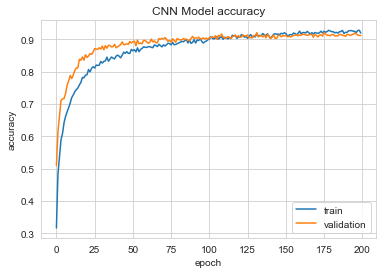

In [68]:
plt.subplots()  # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Loss

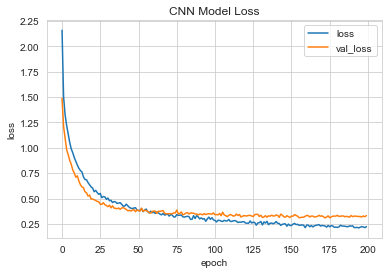

In [69]:
plt.subplots()  # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

In [70]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy)

[0.3312157690525055, 0.9118320345878601]


In [71]:
y_pred = model.predict(X_test)

82/82 [==============================] - 0s 1ms/step


In [72]:

from sklearn import metrics

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [73]:
matrix

array([[324,   0,   1,   1,   0,   4,   0,   0,   0,   6],
       [  0, 122,   0,   3,   0,   0,   0,   0,   0,   8],
       [  0,   2, 271,   7,   4,   0,   1,   4,   3,  16],
       [  0,   2,  22, 243,   8,   4,   1,   0,   5,  12],
       [  0,   0,   1,   5, 289,   2,   0,  12,   0,   7],
       [  1,   0,   6,   1,   0, 282,   0,   0,   1,   1],
       [  0,   0,   6,   8,   1,   1,  91,   0,   0,   1],
       [  0,   0,   0,   1,   5,   0,   0, 272,   0,   3],
       [  0,   0,  10,   4,   0,   1,   0,   3, 259,   0],
       [  1,   1,  18,   3,   4,   5,   0,   2,   2, 236]], dtype=int64)

## Test

In [74]:
def test(filename, model):
    mfccs_scaled_features = dl.get_one_file_features_extractor(filename).reshape(-1, 40, 1)
    predicted_label = np.argmax(model.predict(mfccs_scaled_features), 1)
    print(predicted_label)
    prediction_class = dl.decode_label(predicted_label)
    print(prediction_class)

In [75]:
filename = 'UrbanSound8K/audio/fold5/6508-9-0-1.wav'

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
ipd.Audio(filename)

In [76]:
test(filename, model)

1/1 [==============================] - 0s 72ms/step
[9]
['street_music']
